In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [174]:
def cm2inch(value):
    return value/2.54

In [175]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [176]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [30]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [198]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [177]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    return df

In [269]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45,
                 mem_other=True, mem_total=False):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1

    df_p = pd.pivot_table(df, index=[index], values=values)

    if mem_total:
        df_mem = pd.pivot_table(df, index=[index], values=['Memory per VP'])
    elif mem_other:
        df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    else:
        df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    if mem_total:
        df_mem.plot(kind='bar', capsize=4, legend=False, ax=axes[ncols-1],
                    fontsize=fontsize_axis, rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    else:
        df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                    fontsize=fontsize_axis, rot=rot, color=['tab:purple', 'pink', 'red'])

        plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    #if not mem_total:
    axes[ncols-1].axhline(y=df['Memory per VP'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per VP')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    if not mem_total:
        df_p['connections'] = df_mem['connections']
        df_p['ini'] = df_mem['ini']
        if mem_other:
            df_p['other'] = df_mem['other']
    return df_p

In [248]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Conn. Creation Time \n per Conn. (min)' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [85]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIGURES

## HPC_benchmark

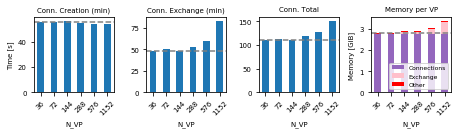

In [270]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
#print(hpc_t6_s20['N_conns_sum'])
#print(hpc_t6_s20['N_nrns'])

## HPC static

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,50.38,44.34,106.29,1.930745,0.082848,0.057636
72,50.39,47.27,108.31,1.930745,0.140628,0.055966
144,50.61,46.64,110.56,1.930745,0.138309,0.053382
288,48.95,49.19,110.87,1.951579,0.350760,0.053393
576,49.90,59.29,121.61,1.993245,0.419607,0.053747
1152,49.24,81.91,144.39,1.993083,0.452431,0.054612


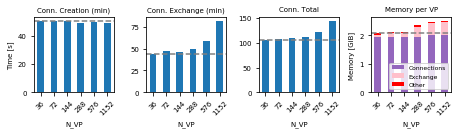

In [271]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_table.txt')
hpc_static_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,59.03,55.15,123.98,2.743245,0.022139,0.051125
72,59.38,62.68,130.93,2.743245,0.036027,0.053362
144,59.12,56.11,126.83,2.743245,0.113203,0.053382
288,57.37,59.52,130.55,2.743245,0.170184,0.053393
576,57.13,66.91,139.17,2.743245,0.520410,0.053747
1152,56.60,91.91,165.08,2.743083,0.604612,0.054612


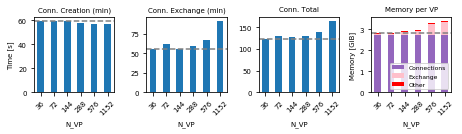

In [272]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_random_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_random_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_random_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,52.94,48.75,108.34,1.930745,0.395348,0.051125
72,53.27,48.90,109.68,1.930745,0.394128,0.053362
144,54.14,52.98,117.80,1.930745,0.403486,0.053382
288,52.39,53.71,117.39,1.951579,0.457815,0.053393
576,52.51,62.07,127.60,1.993245,0.417980,0.053747
1152,52.16,91.93,156.84,1.993083,0.452973,0.054612


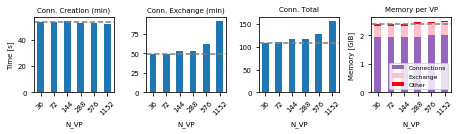

In [273]:
hpc_static_del_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static_random_delays.csv')

hpc_static_del_t6_s20 = calculate_T_conn_and_memory(hpc_static_del_t6_s20)
hpc_static_del_t6_s20_p = plot_results(hpc_static_del_t6_s20,
                                       'benchmark_figures/hpc_benchmark_static_random_delays.pdf')

save_table_latex(hpc_static_del_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_random_delays_table.txt')
hpc_static_del_t6_s20_p

## Comparing different cases from above

Conn. Creation (min)                                                      \
Case              Default Random delay Random delay and static Static synapse   
N_VP                                                                            
36                  55.93        59.03                   52.94          50.38   
72                  56.16        59.38                   53.27          50.39   
144                 56.73        59.12                   54.14          50.61   
288                 55.07        57.37                   52.39          48.95   
576                 53.97        57.13                   52.51          49.90   
1152                53.90        56.60                   52.16          49.24   

     Conn. Exchange (min)                                                      \
Case              Default Random delay Random delay and static Static synapse   
N_VP                                                                            
36                  47.75        55.15                   48.75          44.34   
72                  50.03        62.68                   48.90          47.27   
144                 47.69        56.11                   52.98          46.64   
288                 52.39        59.52                   53.71          49.19   
576                 59.77        66.91                   62.07          59.29   
1152                83.27        91.91                   91.93          81.91   

     Conn. Total                                                      \
Case     Default Random delay Random delay and static Static synapse   
N_VP                                                                   
36        110.79       123.98                  108.34         106.29   
72        113.02       130.93                  109.68         108.31   
144       111.17       126.83                  117.80         110.56   
288       119.53       130.55                  117.39         110.87   
576       126.65       139.17                  127.60         121.61   
1152      150.91       165.08                  156.84         144.39   

     Memory per VP                                                      
Case       Default Random delay Random delay and static Static synapse  
N_VP                                                                    
36        2.822043     2.816509                2.377219       2.071229  
72        2.821839     2.832635                2.378235       2.127340  
144       2.905517     2.909830                2.387614       2.122436  
288       2.910500     2.966822                2.462787       2.355732  
576       3.035068     3.317403                2.464972       2.466600  
1152      3.382232     3.402306                2.500667       2.500125

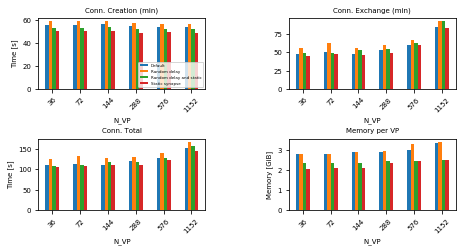

In [274]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_static_t6_s20['Case'] = ['Static synapse'] * len(hpc_static_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_static_del_t6_s20['Case'] = ['Random delay and static'] * len(hpc_static_del_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_static_t6_s20, hpc_delay_t6_s20, hpc_static_del_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf', one_row=False, legend_loc='lower right')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

## Population model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,48.28,39.54,96.29,1.979818,0.105624,0.065204
72,51.07,40.45,101.00,1.975260,0.131666,0.071347
144,56.66,40.79,106.78,1.975260,0.216261,0.071367
288,67.07,44.65,120.55,1.975260,0.129894,0.071378
576,90.89,55.47,208.39,1.975260,0.398448,0.071732
1152,135.16,107.55,271.06,1.975260,0.463761,0.072434


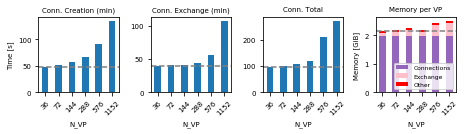

In [302]:
population = pd.read_csv('benchmark_results/population_model_8adec3cd_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

#print(population['N_conns_sum'])
#print(population['N_nrns'])
population_p

## HPC benchmark vs block Population model

Conn. Creation (min)                             Conn. Exchange (min)  \
Case        HPC Benchmark Population Population - old        HPC Benchmark   
N_VP                                                                         
36                  55.93      48.28            45.75                47.75   
72                  56.16      51.07            46.64                50.03   
144                 56.73      56.66            47.91                47.69   
288                 55.07      67.07            50.44                52.39   
576                 53.97      90.89            54.71                59.77   
1152                53.90     135.16            66.78                83.27   

                                   Conn. Total                              \
Case Population Population - old HPC Benchmark Population Population - old   
N_VP                                                                         
36        39.54            39.25        110.79      96.29            93.81   
72        40.45            40.00        113.02     101.00            95.79   
144       40.79            40.45        111.17     106.78            98.53   
288       44.65            43.82        119.53     120.55           103.67   
576       55.47            54.46        126.65     208.39           118.66   
1152     107.55            95.90        150.91     271.06           176.92   

     Memory per VP                              
Case HPC Benchmark Population Population - old  
N_VP                                            
36        2.822043   2.150645         2.150646  
72        2.821839   2.178273         2.170461  
144       2.905517   2.262888         2.262454  
288       2.910500   2.176532         2.163512  
576       3.035068   2.445441         2.445441  
1152      3.382232   2.511455         2.501953

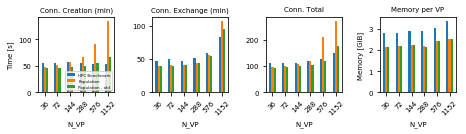

In [303]:
population_old = pd.read_csv('benchmark_results/population_model_8adec3cd_daint_t6_old.csv')
population_old = calculate_T_conn_and_memory(population_old)

hpc_t6_s20['Case'] = ['HPC Benchmark'] * len(hpc_t6_s20)
population['Case'] = ['Population'] * len(population)
population_old['Case'] = ['Population - old'] * len(population_old)

hpc_pop_cases = pd.concat([hpc_t6_s20, population, population_old])

hpc_pop_cases_p = plot_compare(hpc_pop_cases, 'benchmark_figures/hpc_vs_pop.pdf')
save_table_latex(hpc_pop_cases_p.to_latex(), 'latex_tables/hpc_vs_pop_table.txt')

hpc_pop_cases_p

#### time per connection

Conn. Creation Time \n per Conn. (min)             \
Case                          HPC Benchmark Population   
N_VP                                                     
36                                 0.795378   0.658800   
72                                 0.798649   0.671616   
144                                0.806755   0.689904   
288                                0.783148   0.726336   
576                                0.767505   0.787824   
1152                               0.766510   0.961632   

     Conn. Exchange Time \n per Conn. (min)            Memory per connection  \
Case                          HPC Benchmark Population         HPC Benchmark   
N_VP                                                                           
36                                 0.679050   0.565200             42.236336   
72                                 0.711474   0.576000             42.273624   
144                                0.678197   0.582480             43.551069   
288                                0.745036   0.631008             43.626989   
576                                0.849987   0.784224             45.523682   
1152                               1.184179   1.380960             50.803273   

                Total Conn. Time per Conn.             
Case Population              HPC Benchmark Population  
N_VP                                                   
36    32.244856                   1.575539   1.350864  
72    32.456249                   1.607252   1.379376  
144   33.878331                   1.580944   1.418832  
288   32.348318                   1.699831   1.492848  
576   36.702005                   1.801084   1.708704  
1152  37.564931                   2.146085   2.547648

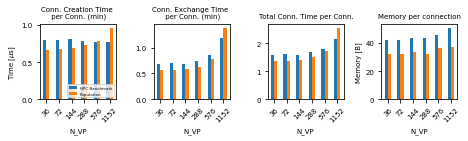

In [277]:
hpc_pop_tpc = time_and_memory_per_connection(hpc_pop_cases)
values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_pop_tpc_p = plot_compare(hpc_pop_tpc, 'benchmark_figures/hpc_vs_pop_cases_time_per_conn.pdf',
                             values, legend_loc='lower right')
save_table_latex(hpc_pop_tpc_p.to_latex(),
                 'latex_tables/hpc_vs_pop_cases_time_per_conn_table.txt')

hpc_pop_tpc_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 5 * NUMBER_OF_NODES`

**Compare *all* rules:**

Conn. Creation (min)                                                    \
Case           all to all fixed indegree fixed outdegree fixed total number   
N_VP                                                                          
36                  12.45          14.28           75.28              16.82   
72                  12.46          14.21          128.24              16.40   
144                 12.38          14.16          232.49              16.31   
288                 12.43          14.11          440.86              16.27   
576                 12.37          13.82          855.70                NaN   
1152                12.38          13.75         1685.13                NaN   

                        Conn. Exchange (min)                                 \
Case pairwise bernoulli           all to all fixed indegree fixed outdegree   
N_VP                                                                          
36                16.30                 9.65          11.16            9.01   
72                19.23                10.88          11.35            9.46   
144               24.42                10.26          11.90           10.08   
288               35.00                11.35          12.47           14.00   
576               56.46                10.63          13.59           12.01   
1152              99.22                11.31          14.48           12.69   

                                           Conn. Total                 \
Case fixed total number pairwise bernoulli  all to all fixed indegree   
N_VP                                                                    
36                11.18              10.63       23.94          27.73   
72                11.41              11.06       26.07          29.52   
144               11.79              11.41       25.64          29.99   
288               12.54              12.26       26.83          31.06   
576                 NaN              13.58       25.84          32.14   
1152                NaN              15.12       27.24          33.00   

                                                           Memory per VP  \
Case fixed outdegree fixed total number pairwise bernoulli    all to all   
N_VP                                                                       
36             88.63              30.34              30.92      0.749755   
72            154.58              32.40              34.27      0.756658   
144           278.94              32.76              40.11      0.761072   
288           484.76              33.38              51.29      0.763594   
576           963.10                NaN              74.32      0.771211   
1152         1796.98                NaN             120.53      0.787419   

                                                                           
Case fixed indegree fixed outdegree fixed total number pairwise bernoulli  
N_VP                                                                       
36         0.754855        0.799072           0.747314           0.754530  
72         0.769299        0.796995           0.762165           0.758394  
144        0.786707        0.817591           0.788687           0.787575  
288        0.836700        0.865889           0.836734           0.835324  
576        0.967500        0.994681                NaN           0.970321  
1152       0.945985        0.966465                NaN           0.947477

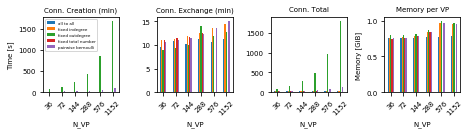

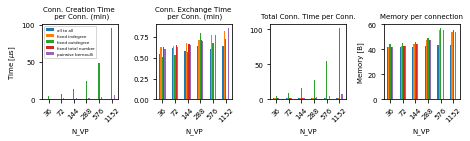

In [289]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_in.csv')
hpc_in['Case'] = ['fixed indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_out.csv')
hpc_out['Case'] = ['fixed outdegree']*len(hpc_out)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_all.csv')
hpc_all['Case'] = ['all to all']*len(hpc_all)

hpc_tot = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot.csv')
# We take out relevant values because fixed_total_number cannon create connections when we get over a certain point 
hpc_tot.loc[4, ['T_conns_min', 'T_conns_max', 'T_ini_min', 'T_ini_max', 'VSize_mem_sum', 'VSize_nodes_sum',
                'VSize_ini_sum', 'VSize_sum', ]] = np.NaN
hpc_tot.loc[5, ['T_conns_min', 'T_conns_max', 'T_ini_min', 'T_ini_max', 'VSize_mem_sum', 'VSize_nodes_sum',
                'VSize_ini_sum', 'VSize_sum', ]] = np.NaN
hpc_tot['Case'] = ['fixed total number']*len(hpc_tot)

#hpc_tot_nosort = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot_nosort.csv')
#hpc_tot_nosort['Case'] = ['fixed total number no sort']*len(hpc_tot_nosort)

#hpc_tot_gsl = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot_gsl.csv')
#hpc_tot_gsl['Case'] = ['fixed total number gsl']*len(hpc_tot_gsl)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_bern.csv')
hpc_bern['Case'] = ['pairwise bernoulli']*len(hpc_bern)

hpc_rules = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot, hpc_out])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules_tpc = time_and_memory_per_connection(hpc_rules)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_loc='upper left',
                           color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')

hpc_rules_tpc_p = plot_compare(hpc_rules_tpc, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                               values, legend_loc='upper left', logy=False,
                               color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
save_table_latex(hpc_rules_tpc_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

# print("fixed indegree:")
# print(hpc_in['N_conns_sum'])
# print(hpc_in['N_nrns'])

# print("fixed_outdegree:")
# print(hpc_out['N_conns_sum'])
# print(hpc_out['N_nrns'])

# print("fixed_total_number:")
# print(hpc_tot['N_conns_sum'])
# print(hpc_tot['N_nrns'])

# print("fixed_total_number no sort:")
# print(hpc_tot_nosort['N_conns_sum'])
# print(hpc_tot_nosort['N_nrns'])

# print("all to all:")
# print(hpc_all['N_conns_sum'])
# print(hpc_all['N_nrns'])

# print("bernoulli:")
# print(hpc_bern['N_conns_sum'])
# print(hpc_bern['N_nrns'])

**Not including `fixed outdegree`:**

Conn. Creation (min)                                    \
Case           all to all fixed indegree fixed total number   
N_VP                                                          
36                  12.45          14.28              16.82   
72                  12.46          14.21              16.40   
144                 12.38          14.16              16.31   
288                 12.43          14.11              16.27   
576                 12.37          13.82                NaN   
1152                12.38          13.75                NaN   

                        Conn. Exchange (min)                 \
Case pairwise bernoulli           all to all fixed indegree   
N_VP                                                          
36                16.30                 9.65          11.16   
72                19.23                10.88          11.35   
144               24.42                10.26          11.90   
288               35.00                11.35          12.47   
576               56.46                10.63          13.59   
1152              99.22                11.31          14.48   

                                           Conn. Total                 \
Case fixed total number pairwise bernoulli  all to all fixed indegree   
N_VP                                                                    
36                11.18              10.63       23.94          27.73   
72                11.41              11.06       26.07          29.52   
144               11.79              11.41       25.64          29.99   
288               12.54              12.26       26.83          31.06   
576                 NaN              13.58       25.84          32.14   
1152                NaN              15.12       27.24          33.00   

                                           Memory per VP                 \
Case fixed total number pairwise bernoulli    all to all fixed indegree   
N_VP                                                                      
36                30.34              30.92      0.749755       0.754855   
72                32.40              34.27      0.756658       0.769299   
144               32.76              40.11      0.761072       0.786707   
288               33.38              51.29      0.763594       0.836700   
576                 NaN              74.32      0.771211       0.967500   
1152                NaN             120.53      0.787419       0.945985   

                                            
Case fixed total number pairwise bernoulli  
N_VP                                        
36             0.747314           0.754530  
72             0.762165           0.758394  
144            0.788687           0.787575  
288            0.836734           0.835324  
576                 NaN           0.970321  
1152                NaN           0.947477

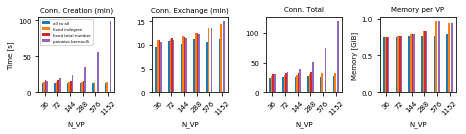

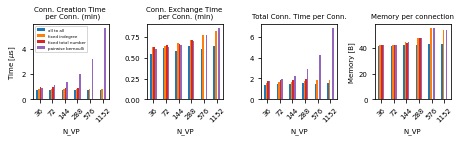

In [292]:
hpc_rules_no_out = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot])

hpc_rules_no_out = calculate_T_conn_and_memory(hpc_rules_no_out)
hpc_rules_no_out_tpc = time_and_memory_per_connection(hpc_rules_no_out)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_rules_no_out_p = plot_compare(hpc_rules_no_out, 'benchmark_figures/hpc_rules_no_out.pdf',
                                  color=['tab:blue', 'tab:orange', 'tab:red', 'tab:purple'],
                                  legend_loc='upper left')
save_table_latex(hpc_rules_no_out_p.to_latex(), 'latex_tables/hpc_rules_no_out_table.txt')
hpc_rules_no_out_tpc_p = plot_compare(hpc_rules_no_out_tpc,
                                      'benchmark_figures/hpc_rules_no_out_time_per_connection.pdf', values,
                                      color=['tab:blue', 'tab:orange', 'tab:red', 'tab:purple'],
                                      legend_loc='upper left')
save_table_latex(hpc_rules_no_out_tpc_p.to_latex(), 'latex_tables/hpc_rules_no_out_time_per_connection_table.txt')

hpc_rules_no_out_p

**Not including `fixed total number`:**

Conn. Creation (min)                                                    \
Case           all to all fixed indegree fixed outdegree pairwise bernoulli   
N_VP                                                                          
36                  12.45          14.28           75.28              16.30   
72                  12.46          14.21          128.24              19.23   
144                 12.38          14.16          232.49              24.42   
288                 12.43          14.11          440.86              35.00   
576                 12.37          13.82          855.70              56.46   
1152                12.38          13.75         1685.13              99.22   

     Conn. Exchange (min)                                                    \
Case           all to all fixed indegree fixed outdegree pairwise bernoulli   
N_VP                                                                          
36                   9.65          11.16            9.01              10.63   
72                  10.88          11.35            9.46              11.06   
144                 10.26          11.90           10.08              11.41   
288                 11.35          12.47           14.00              12.26   
576                 10.63          13.59           12.01              13.58   
1152                11.31          14.48           12.69              15.12   

     Conn. Total                                                    \
Case  all to all fixed indegree fixed outdegree pairwise bernoulli   
N_VP                                                                 
36         23.94          27.73           88.63              30.92   
72         26.07          29.52          154.58              34.27   
144        25.64          29.99          278.94              40.11   
288        26.83          31.06          484.76              51.29   
576        25.84          32.14          963.10              74.32   
1152       27.24          33.00         1796.98             120.53   

     Memory per VP                                                    
Case    all to all fixed indegree fixed outdegree pairwise bernoulli  
N_VP                                                                  
36        0.749755       0.754855        0.799072           0.754530  
72        0.756658       0.769299        0.796995           0.758394  
144       0.761072       0.786707        0.817591           0.787575  
288       0.763594       0.836700        0.865889           0.835324  
576       0.771211       0.967500        0.994681           0.970321  
1152      0.787419       0.945985        0.966465           0.947477

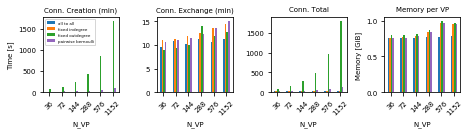

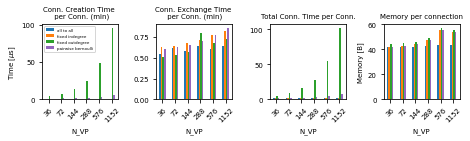

In [280]:
hpc_rules_no_tot = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_out])

hpc_rules_no_tot = calculate_T_conn_and_memory(hpc_rules_no_tot)
hpc_rules_no_tot_tpc = time_and_memory_per_connection(hpc_rules_no_tot)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_no_tot.pdf',
                                  color=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple'],
                                  legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_table.txt')
hpc_rules_no_tot_tpc_p = plot_compare(hpc_rules_no_tot_tpc,
                                      'benchmark_figures/hpc_rules_not_tot_time_per_connection.pdf', values,
                                      color=['tab:blue', 'tab:orange', 'tab:green', 'tab:purple'],
                                      legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_tpc_p.to_latex(), 'latex_tables/hpc_rules_no_tot_time_per_connection_table.txt')

hpc_rules_no_tot_p

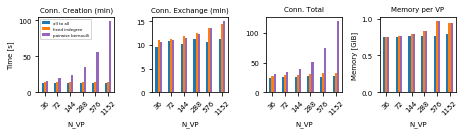

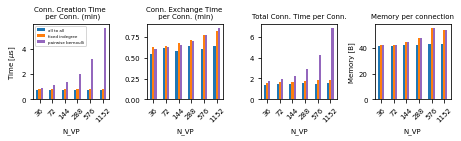

In [291]:
hpc_rules_no_fo = pd.concat([hpc_in, hpc_bern, hpc_all])

hpc_rules_no_fo = calculate_T_conn_and_memory(hpc_rules_no_fo)
hpc_rules_no_fo_tpc = time_and_memory_per_connection(hpc_rules_no_fo)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_rules_no_fo_p = plot_compare(hpc_rules_no_fo, 'benchmark_figures/hpc_rules_no_out_or_tot.pdf',
                                 color=['tab:blue', 'tab:orange', 'tab:purple'],
                                 legend_loc='upper left')
save_table_latex(hpc_rules_no_fo_p.to_latex(), 'latex_tables/hpc_rules_no_out_or_tot_table.txt')
hpc_rules_no_fo_tpc_p = plot_compare(hpc_rules_no_fo_tpc,
                                     'benchmark_figures/hpc_rules_no_out_or_tot_time_per_connection.pdf', values,
                                     color=['tab:blue', 'tab:orange', 'tab:purple'],
                                     legend_loc='upper left')
save_table_latex(hpc_rules_no_fo_tpc_p.to_latex(),
                 'latex_tables/hpc_rules_no_out_ot_tot_time_per_connection_table.txt')


## Multi-Area Model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total
N_VP,,,
36,120.426247,36.050572,156.477170
72,157.620768,36.592974,194.214109
144,244.647294,39.647938,284.296193
288,409.156298,43.565511,452.722374
576,730.886775,35.718095,766.605952
1152,1437.297899,62.590330,1499.890033


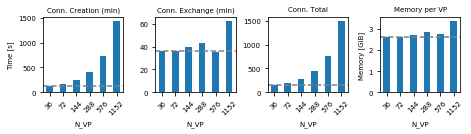

In [282]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_8adec3cd_daint_t6.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)

MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', mem_total=True)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')

MAM_t6_s0_0625_p

# print(MAM_t6_s0_0625['N_conns_sum'])
# print(MAM_t6_s0_0625['N_nrns'])

## 4x4 mesocircuit

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,171.05,6.04,177.09,0.500407,0.118544,0.051779
72,194.96,6.58,201.55,0.519694,0.103678,0.066061
144,227.96,8.07,236.04,0.538167,0.124051,0.077799
288,333.89,8.96,342.87,0.453717,0.176499,0.105154
576,521.29,10.29,531.64,0.407574,0.230692,0.173216
1152,964.58,13.71,978.42,0.408856,0.366698,0.305754


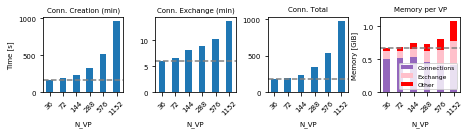

In [283]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_8adec4cd_daint_t6.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=False)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')

meso_t6_s0_0625_p

# print(meso_t6_s0_0625['N_conns_sum'])
# print(meso_t6_s0_0625['N_nrns'])

## Comapare hpc, population, MAM and 4x4

Conn. Creation Time \n per Conn. (min)                           \
Case                                    4x4 HPC random delay, static   
N_VP                                                                   
36                                17.825790                 0.752857   
72                                20.316339                 0.757550   
144                               23.753340                 0.769923   
288                               34.791047                 0.745036   
576                               54.317855                 0.746742   
1152                             100.507309                 0.741765   

                           Conn. Exchange Time \n per Conn. (min)  \
Case        MAM Population                                    4x4   
N_VP                                                                
36     2.874098   0.658800                               0.629452   
72     3.761778   0.671616                               0.685687   
144    5.838750   0.689904                               0.840891   
288    9.764916   0.726336                               0.933624   
576   17.443326   0.787824                               1.072207   
1152  34.302514   0.961632                               1.428555   

                                                   Memory per connection  \
Case HPC random delay, static       MAM Population                   4x4   
N_VP                                                                       
36                   0.693271  0.860384   0.565200             69.259867   
72                   0.695405  0.873328   0.576000             69.750507   
144                  0.753426  0.946237   0.582480             74.091230   
288                  0.763808  1.039734   0.631008             70.510432   
576                  0.882695  0.852447   0.784224             71.410931   
1152                 1.307333  1.493779   1.380960             86.770370   

                                         Total Conn. Time per Conn.  \
Case HPC random delay, static Population                        4x4   
N_VP                                                                  
36                  35.518593  32.244856                  18.455242   
72                  35.499961  32.456249                  21.003068   
144                 35.642868  33.878331                  24.595272   
288                 36.790571  32.348318                  35.726755   
576                 36.818531  36.702005                  55.396314   
1152                37.350384  37.564931                 101.949410   

                                                     
Case HPC random delay, static        MAM Population  
N_VP                                                 
36                   1.540698   3.734491   1.350864  
72                   1.559754   4.635115   1.379376  
144                  1.675229   6.785010   1.418832  
288                  1.669398  10.804663   1.492848  
576                  1.814594  18.295799   1.708704  
1152                 2.230415  35.796336   2.547648

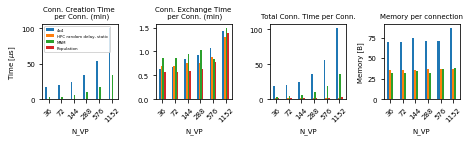

In [284]:
hpc_static_del_t6_s20[['Case']] = ['HPC random delay, static']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['Population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_static_del_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_and_memory_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper left')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
Threads,,,,,,
1,17.40,11.70,29.40,1.915039,0.795025,0.386829
3,31.06,24.88,59.71,1.930013,0.293794,0.089876
6,41.26,34.54,81.53,1.995850,0.075687,0.047707
9,43.63,45.66,89.95,1.974826,0.076844,0.038896
18,57.58,71.10,130.47,1.953695,0.014393,0.040708
36,73.43,77.09,150.52,1.943454,0.020833,0.035204


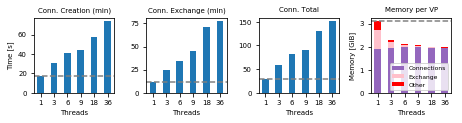

In [285]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                         Conn. Exchange (min)  \
Case                    2.14    2.16   2.18 8adec3cd                 2.14   
Threads                                                                     
1                      36.44   21.73  17.62    17.40                 0.62   
3                      47.89   38.73  30.85    31.06                 0.89   
6                      52.17   51.38  42.25    41.26                 0.96   
9                      53.47   58.84  43.85    43.63                 0.91   
18                     54.55   81.97  56.37    57.58                 1.38   
36                     61.78  124.92  74.22    73.43                 1.44   

                               Conn. Total                           \
Case      2.16   2.18 8adec3cd        2.14    2.16    2.18 8adec3cd   
Threads                                                               
1        18.79  11.87    11.70       38.13   41.59   29.74    29.40   
3        29.74  24.27    24.88       53.94   74.21   61.06    59.71   
6        35.99  32.64    34.54       55.97   89.20   78.62    81.53   
9        50.30  48.41    45.66       56.75  110.85   93.32    89.95   
18       66.25  68.98    71.10       58.47  151.96  127.35   130.47   
36       91.19  77.44    77.09       63.22  216.11  151.66   150.52   

        Memory per VP                                
Case             2.14      2.16      2.18  8adec3cd  
Threads                                              
1            2.312773  5.072531  3.096897  3.096893  
3            2.028328  4.422857  2.269574  2.313683  
6            1.983972  4.332034  2.121685  2.119244  
9            1.973401  4.311907  2.100494  2.090566  
18           1.963256  4.293865  2.008091  2.008796  
36           1.968212  4.284930  1.989075  1.999492

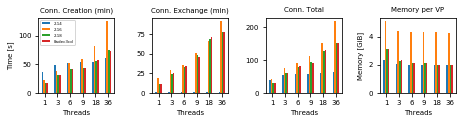

In [286]:
hpc_threads_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_threads_218['Case'] = ['2.18']*len(hpc_threads_218)
hpc_threads_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')
hpc_threads_m['Case']   = ['8adec3cd']*len(hpc_threads_m)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_218, hpc_threads_m])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/hpc_fixedVP_diff_threads_comparison.pdf',
                             index='Threads', rot=0, legend_loc='upper left')
save_table_latex(hpc_threads_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_comparison.txt')

hpc_threads_p

Conn. Total                        Memory per VP                      \
Case        2.14   2.16   2.18 8adec3cd          2.14      2.16      2.18   
N_VP                                                                        
36         37.39  41.12  29.69    29.57      2.312611  5.072531  3.096897   
72         39.99  42.98  29.81    29.34      2.327074  5.073708  3.107514   
144        42.03  45.60  30.39    30.19      2.707514  5.075892  3.109698   
288        44.44  46.59  31.11    31.17      3.149024  5.080248  3.114054   
576        46.74  48.86  33.61    34.08      3.144015  5.108859  3.578192   
1152       49.62  55.41  39.56    40.25      3.161597  5.123802  4.092529   

               Simulation                           
Case  8adec3cd       2.14    2.16    2.18 8adec3cd  
N_VP                                                
36    3.096893      82.85   88.38   90.13    89.62  
72    3.107514      84.19   87.63   90.85    90.32  
144   3.109698      87.78   92.08   95.31    94.96  
288   3.114054      97.88  105.33  105.49   106.58  
576   3.577714     110.44  119.03  128.16   128.64  
1152  4.092366     140.54  163.31  172.90   173.25

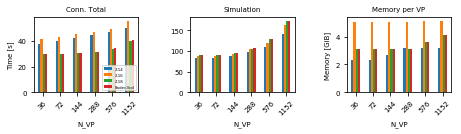

In [287]:
hpc_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_n1_s15.csv')
hpc_m['Case']   = ['8adec3cd']*len(hpc_m)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['num. nodes'] = hpc_versions['NUMBER_OF_NODES']
hpc_versions['Simulation'] = hpc_versions['T_sim']
hpc_versions_p = plot_compare(hpc_versions, 'benchmark_figures/hpc_different_versions.pdf',
                              values = ['Conn. Total', 'Simulation', 'Memory per VP'],
                              rot=45)
save_table_latex(hpc_versions_p.to_latex(), 'latex_tables/hpc_different_versions.txt')

hpc_versions_p